In [1]:
import boto3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Getting Tokens

In [2]:
TABLE = "domains"

def add_to_tokens_list(tokens, costs, items):
    for item in items:
        tokens[item["domain_name"]] = item["tokens"]
        costs[item["domain_name"]] = float(item["total_spent"]) #DynamoDB stores as Decimal

    return tokens, costs


def get_tokens():
    tokens = {}
    costs = {}

    dynamo = boto3.resource("dynamodb").Table(TABLE)

    res = dynamo.scan()
    tokens, costs = add_to_tokens_list(tokens, costs, res["Items"])

    while "LastEvaluatedKey" in res:
        res = dynamo.scan(ExclusiveStartKey=res["LastEvaluatedKey"])
        tokens = add_to_tokens_list(tokens, res["Items"])

    return tokens, costs

In [3]:
tokens, costs = get_tokens()
list(tokens.keys())

['prestigeglobalchem.com',
 'omaghenshihtzuhome.com',
 'southhilltoppuppies.com',
 'johnbellteacupmaltese.com',
 'CJKETAMINESTORE.NET',
 'purechempharma.com',
 'tomh.uk',
 'monarchbulldogs-sa.com',
 'jungleboyspacks.com',
 'FAITHSTANDARDPHARMACY.COM',
 'premiumdachshundpups.com',
 'K2DRUGSTORE.COM',
 'STRANDNORDBV.COM',
 'SKYPHARMACYPILS.COM',
 'vland-official.com',
 'megaketaminestore.com',
 'ketamineforsale.com',
 'shihtzupuppiesforsale-us.com',
 'MORRISAPOTEK.COM',
 'percocetpills.com',
 'pelluciddalmatianpuppieshome.com',
 'DROMEDARYVILLE.COM',
 'ROYALSITEYORKSHIRETERRIERPUPPIES.COM',
 'PUPPYSTASHKENNELAU.COM',
 'cutestdoodleskennel.com',
 'bradsmaltipoos.com']

In [4]:
import torch
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

# tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")

# model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

In [7]:
candidate_labels = ['pets', 'drugs', 'automotive', 'pharmacy']
classifier(' '.join(tokens['megaketaminestore.com']), candidate_labels)

{'sequence': 'home buy ketamin onlin skip contentbuy ketamin onlineleg ketamin shop ketamin sale onlinehom shop contact us us ship inform account cart checkout buy ketamin onlin ketamin sale ketamin onlin store legal ketamin product ketaminebuy ketamin hcl liquid onlin add cart ketaminebuy ketamin powder onlin add cart ketamin buy ketamin liquid onlin add cart ketamin ketamin brand name ketalar dissoci anesthet block sensori percept avail prescript ketamin drug sinc human veterinari use dissoci drug lead distort sight color sound self one environ ketamin clinic avail clear liquid powder form intraven inject ketamin depress treatment dissoci drug includ phencyclidin pcp dextromethorphan dxm ketamin provid pain relief memori loss exampl amnesia medic procedur surgeri use induct mainten agent sedat provid general anesthesia also use pain control burn therapi ketamin side effect battlefield injuri children use anesthet due side effect allergi drug also research hold promis treatment sever 

In [6]:
candidate_labels = ['pets', 'drugs', 'automotive', 'pharmacy']
result = {'drugs': [], 'pharmacy': [], 'automotive': [], 'pets': []}

for key, val in tqdm(tokens.items()):
    res = classifier(' '.join(val), candidate_labels)
    result[res["labels"][0]].append(key)


  0%|          | 0/26 [00:00<?, ?it/s]

In [7]:
result

{'drugs': ['prestigeglobalchem.com',
  'CJKETAMINESTORE.NET',
  'SKYPHARMACYPILS.COM',
  'megaketaminestore.com',
  'ketamineforsale.com'],
 'pharmacy': ['purechempharma.com',
  'jungleboyspacks.com',
  'FAITHSTANDARDPHARMACY.COM',
  'K2DRUGSTORE.COM',
  'STRANDNORDBV.COM',
  'MORRISAPOTEK.COM',
  'percocetpills.com',
  'DROMEDARYVILLE.COM'],
 'automotive': ['tomh.uk', 'vland-official.com'],
 'pets': ['omaghenshihtzuhome.com',
  'southhilltoppuppies.com',
  'johnbellteacupmaltese.com',
  'monarchbulldogs-sa.com',
  'premiumdachshundpups.com',
  'shihtzupuppiesforsale-us.com',
  'pelluciddalmatianpuppieshome.com',
  'ROYALSITEYORKSHIRETERRIERPUPPIES.COM',
  'PUPPYSTASHKENNELAU.COM',
  'cutestdoodleskennel.com',
  'bradsmaltipoos.com']}

In [145]:
#0=pharmacy, 1=ketamine, 2=cannabis, 3=cars, 4=other 
y = [0, 1, 0, 4, 2, 0, 2, 3, 1, 1, 0]

In [146]:
costs

{'prestigeglobalchem.com': 36.5,
 'omaghenshihtzuhome.com': 16.88,
 'southhilltoppuppies.com': 16.88,
 'johnbellteacupmaltese.com': 12.0,
 'CJKETAMINESTORE.NET': 55.0,
 'purechempharma.com': 24.0,
 'tomh.uk': 18.0,
 'monarchbulldogs-sa.com': 16.88,
 'jungleboyspacks.com': 16.88,
 'FAITHSTANDARDPHARMACY.COM': 12.0,
 'premiumdachshundpups.com': 12.0,
 'K2DRUGSTORE.COM': 18.0,
 'STRANDNORDBV.COM': 12.0,
 'SKYPHARMACYPILS.COM': 12.0,
 'vland-official.com': 123.66875982284546,
 'megaketaminestore.com': 24.0,
 'ketamineforsale.com': 28.88,
 'shihtzupuppiesforsale-us.com': 16.88,
 'MORRISAPOTEK.COM': 12.0,
 'percocetpills.com': 24.0,
 'pelluciddalmatianpuppieshome.com': 16.88,
 'DROMEDARYVILLE.COM': 25.0,
 'ROYALSITEYORKSHIRETERRIERPUPPIES.COM': 12.0,
 'PUPPYSTASHKENNELAU.COM': 12.0,
 'cutestdoodleskennel.com': 16.88,
 'bradsmaltipoos.com': 12.0}

# TFIDF Vectorizing

In [438]:
#Would use lambda for this but TfidfVectorizer is weird about lambdas
def identity(token):
    return token

tfidf = TfidfVectorizer(max_df=0.45, min_df=1, stop_words='english', use_idf=True, tokenizer=identity, preprocessor=identity, token_pattern=None)

tfidf_matrix = tfidf.fit_transform(list(tokens.values()))

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [439]:
tfidf.stop_words_

{'avail',
 'best',
 'buy',
 'cart',
 'contact',
 'content',
 'copyright',
 'custom',
 'day',
 'deliveri',
 'email',
 'experi',
 'guarante',
 'home',
 'need',
 'offer',
 'onlin',
 'peopl',
 'polici',
 'product',
 'qualiti',
 'quick',
 'right',
 'sale',
 'search',
 'servic',
 'ship',
 'skip',
 'work',
 'year'}

In [410]:
tfidf_data = pd.concat([pd.DataFrame(tokens.keys(), columns=["Domain"]), pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())],axis=1)
tfidf_data[["Domain", "ketamin", "marijuana", "xanax"]]

,Domain,ketamin,marijuana,xanax
0,prestigeglobalchem.com,0.167181,0.000000,0.000000
1,omaghenshihtzuhome.com,0.000000,0.000000,0.000000
2,southhilltoppuppies.com,0.000000,0.000000,0.000000
3,johnbellteacupmaltese.com,0.000000,0.000000,0.000000
4,CJKETAMINESTORE.NET,0.779589,0.000000,0.027449
5,purechempharma.com,0.103727,0.000000,0.060261
6,tomh.uk,0.000000,0.000000,0.000000
7,monarchbulldogs-sa.com,0.000000,0.000000,0.000000
8,jungleboyspacks.com,0.000000,0.651054,0.094796
9,FAITHSTANDARDPHARMACY.COM,0.000000,0.000000,0.000000


# KMeans

## Silhouette

In [232]:
s = []
sse = []
k_max = 10

for k in range(2, k_max):
    kmeans = KMeans(random_state=4, n_clusters=k, n_init=100)
    kmeans.fit(tfidf_matrix)
    
    s.append(silhouette_score(tfidf_matrix, kmeans.labels_, metric="euclidean"))
    sse.append(kmeans.inertia_)

In [256]:
best_k = s.index(max(s)) + 2
print(best_k)

secondDerivative = [sse[i+1] + sse[i-1] - 2 * sse[i] for i in range(1, len(sse) - 1)]
print(secondDerivative)
print(secondDerivative.index(max(secondDerivative)) + 1)

9
[0.5424985963845046, -0.0920751020491295, 0.09667950792029245, -0.05889683959028247, 0.15469865821849638, -0.1767084245839463]
1


Text(0, 0.5, 'SSE')

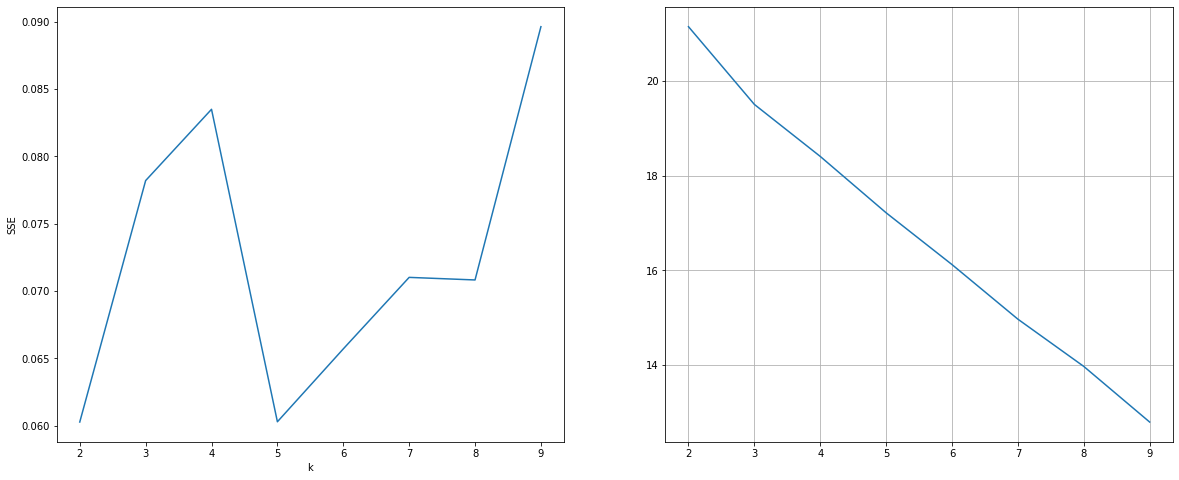

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

plt.grid()
ax[0].plot(list(range(2, k_max)), s)
ax[0].set_xlabel("k")
ax[0].set_ylabel("Silhouette Score")

ax[1].plot(list(range(2, k_max)), sse)
ax[0].set_xlabel("k")
ax[0].set_ylabel("SSE")

In [235]:
kmeans = KMeans(random_state=1, n_clusters=4)

kmeans.fit(tfidf_matrix)

clusters = kmeans.labels_.tolist()

In [236]:
domains = {'domain': tokens.keys(), 'cluster': clusters, 'total_spent': list(costs.values())}

df = pd.DataFrame(domains, index=[clusters], columns=['domain', 'cluster', 'total_spent'])

In [237]:
df['cluster'].value_counts()

0    10
2     7
1     5
3     4
Name: cluster, dtype: int64

In [238]:
df

,domain,cluster,total_spent
0,prestigeglobalchem.com,0,36.50000
1,omaghenshihtzuhome.com,1,16.88000
2,southhilltoppuppies.com,2,16.88000
2,johnbellteacupmaltese.com,2,12.00000
3,CJKETAMINESTORE.NET,3,55.00000
0,purechempharma.com,0,24.00000
1,tomh.uk,1,18.00000
1,monarchbulldogs-sa.com,1,16.88000
0,jungleboyspacks.com,0,16.88000
0,FAITHSTANDARDPHARMACY.COM,0,12.00000


In [239]:
grouped_total_spent = df['total_spent'].groupby(df['cluster'])

grouped_total_spent.mean()

cluster
0    29.804876
1    16.128000
2    14.091429
3    31.470000
Name: total_spent, dtype: float64

In [240]:
grouped_df = df.groupby('cluster')

In [241]:
for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

                      domain  cluster  total_spent
0     prestigeglobalchem.com        0     36.50000
0         purechempharma.com        0     24.00000
0        jungleboyspacks.com        0     16.88000
0  FAITHSTANDARDPHARMACY.COM        0     12.00000
0           STRANDNORDBV.COM        0     12.00000
0        SKYPHARMACYPILS.COM        0     12.00000
0         vland-official.com        0    123.66876
0           MORRISAPOTEK.COM        0     12.00000
0          percocetpills.com        0     24.00000
0         DROMEDARYVILLE.COM        0     25.00000 


                         domain  cluster  total_spent
1        omaghenshihtzuhome.com        1        16.88
1                       tomh.uk        1        18.00
1        monarchbulldogs-sa.com        1        16.88
1      premiumdachshundpups.com        1        12.00
1  shihtzupuppiesforsale-us.com        1        16.88 


                                 domain  cluster  total_spent
2               southhilltoppuppies.com        

# BIRCH

In [19]:
from sklearn.cluster import Birch

In [440]:
s = []
k_max = 10

for k in range(2, k_max):
    kmeans = Birch(n_clusters=k, threshold=0.45)
    kmeans.fit(tfidf_matrix)
    
    s.append(silhouette_score(tfidf_matrix, kmeans.labels_, metric="euclidean"))
    
best_k = s.index(max(s)) + 2
best_k

5

In [441]:
brc = Birch(n_clusters=best_k, threshold=0.45)
brc.fit(tfidf_matrix)

Birch(n_clusters=5, threshold=0.45)

In [442]:
from joblib import dump, load
dump(brc, 'brc-clustering.joblib')

test = load('brc-clustering.joblib')

In [443]:
birch_clusters = brc.labels_.tolist()

birch_domains = {'domain': tokens.keys(), 'cluster': birch_clusters, 'total_spent': list(costs.values()), 'tokens': tokens.values()}

birch_df = pd.DataFrame(birch_domains, index=[birch_clusters], columns=['domain', 'cluster', 'total_spent', 'tokens'])

birch_grouped_df = birch_df.sort_values(by=['cluster'])
birch_grouped_df

,domain,cluster,total_spent,tokens
0,DROMEDARYVILLE.COM,0,25.00000,"[home, dromedari, vill, skip, content, dromeda..."
0,tomh.uk,0,18.00000,"[home, tom, hainestom, hainesprojectsgithubcom..."
0,monarchbulldogs-sa.com,0,16.88000,"[home, monarch, bulldog, sa, email, monarchbul..."
0,percocetpills.com,0,24.00000,"[percocet, pain, pill, sale, buy, blue, percoc..."
0,MORRISAPOTEK.COM,0,12.00000,"[köp, droger, onlin, onlin, apotek, doc, morri..."
0,K2DRUGSTORE.COM,0,18.00000,"[home, page, buy, liquid, paper, liquid, sale,..."
0,vland-official.com,0,123.66876,"[vland, lead, modifi, perform, car, light, man..."
1,STRANDNORDBV.COM,1,12.00000,"[strand, noord, info, email, us, contact, us, ..."
1,jungleboyspacks.com,1,16.88000,"[home, st, los, angel, support, request, quot,..."
1,SKYPHARMACYPILS.COM,1,12.00000,"[home, sky, pharmaci, pil, product, search, ca..."


In [421]:
# birch_df.sort_values(by=['cluster'])

# for i in range(best_k):
#     cluster = birch_df[birch_df['cluster'] == i]
#     cluster_tokens = [set(list(cluster.iloc[[i]]['tokens'])[0]) for i in range(1, len(cluster))]
#     words = set(list(cluster.iloc[[0]]['tokens'])[0]).intersection(*cluster_tokens)
#     print(words)

In [444]:
# tfidf_data
candidate_labels = ['pets', 'drugs', 'automotive', 'pharmacy']

def get_val(domain, x):
    try:
        return float(tfidf_data[tfidf_data["Domain"] == domain][x])
    except:
        return -1

for i in range(best_k):
    cluster = birch_df[birch_df['cluster'] == i]
    for idx, row in cluster.iterrows():
        subset_tokens = row["tokens"]
        classifier(' '.join(subset_tokens), candidate_labels)
#         subset_tokens.sort(key=lambda x: get_val(row["domain"], x), reverse=True)
#         print(f"Domain: {row['domain']}  {list(set(subset_tokens))[0:5]}")

Domain: tomh.uk  ['iot', 'accross', 'consult', 'system', 'whole']
Domain: monarchbulldogs-sa.com  ['plus', 'deliveri', 'interest', 'eas', 'flight']
Domain: K2DRUGSTORE.COM  ['access', 'deliveri', 'especi', 'us', 'defin']
Domain: vland-official.com  ['superb', 'twitter', 'pickup', 'mitsubishi', 'close']
Domain: MORRISAPOTEK.COM  ['eller', 'mdma', 'helgdagar', 'bästa', 'patient']
Domain: percocetpills.com  ['temperatur', 'us', 'weak', 'weight', 'ordr']
Domain: DROMEDARYVILLE.COM  ['sport', 'mealtim', 'absorb', 'vetoquinol', 'us']
Domain: jungleboyspacks.com  ['boy', 'reseach', 'deliveri', 'pickup', 'us']
Domain: STRANDNORDBV.COM  ['quotat', 'close', 'nl', 'grow', 'stadion']
Domain: SKYPHARMACYPILS.COM  ['cartoxycodon', 'secur', 'deliveri', 'us', 'wrinkl']
Domain: omaghenshihtzuhome.com  ['spoil', 'manner', 'yes', 'nella', 'bark']
Domain: shihtzupuppiesforsale-us.com  ['adapt', 'famili', 'interest', 'tall', 'grow']
Domain: southhilltoppuppies.com  ['famili', 'interest', 'everywher', 'pupp

In [447]:
def document_features(document):
    return dict([('contains-word(%s)' % w, True) for w in document])

from nltk.corpus import gutenberg
import nltk

for fileid in gutenberg.fileids(): 
     doc = gutenberg.words(fileid) 
     print(fileid, nltk.classifier.classify(document_features(doc))) 

AttributeError: module 'nltk' has no attribute 'classifier'

# ANN from BIRCH

In [74]:
brc.subcluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.01929042, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
from sklearn.neural_network import MLPClassifier

In [51]:
list(tokens.keys())[0]

'prestigeglobalchem.com'

In [50]:
feature_names = tfidf.get_feature_names()

new_tfidf = TfidfVectorizer(max_df=0.8, min_df=1, stop_words='english', tokenizer=identity, preprocessor=identity, token_pattern=None, vocabulary=feature_names)

doc = [list(tokens.values())[0]]

brc.predict(new_tfidf.fit_transform(doc))

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


array([3])

In [53]:
dump(new_tfidf, 'tfidf.joblib')

test_tfidf = load('tfidf.joblib')

brc.predict(test_tfidf.fit_transform(doc))

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


array([3])

In [27]:
X = [tfidf.fit_transform(item) for item in tokens.values()]
# clf = MLPClassifier(random_state=1, max_iter=300).fit(X, birch_clusters)

ValueError: setting an array element with a sequence.

# Hierarchical

In [205]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

In [206]:
dist = 1 - cosine_similarity(tfidf_matrix)

Z = ward(dist)

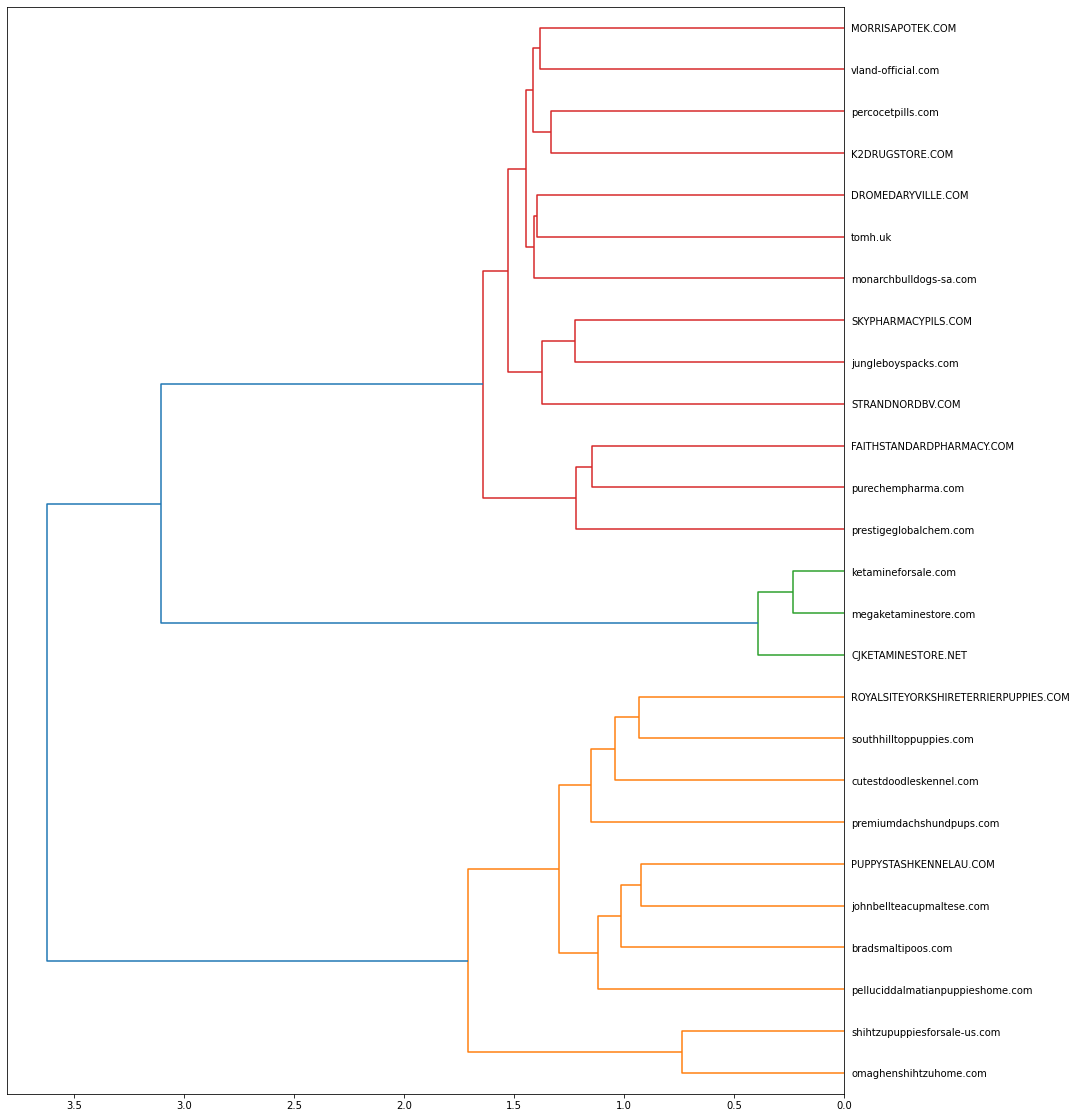

In [207]:
fig, ax = plt.subplots(figsize=(15,20))
ax = dendrogram(Z, orientation="left", labels=list(tokens.keys()))

In [68]:
fcluster(Z, 0.9, criterion='distance')

array([7, 1, 5, 4, 8, 6, 9, 2, 1, 1, 3], dtype=int32)

# T-SNE

In [142]:
from sklearn.manifold import TSNE

In [143]:
tsne = TSNE(n_components=2, learning_rate='auto')

TSNE_clusters = tsne.fit_transform(tfidf_matrix)

/home/connor/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [161]:
TSNE_clusters

data = {'tsne-1': TSNE_clusters[:, 0], 'tsne-2': TSNE_clusters[:, 1], 'y': y}

plot_tsne_df = pd.DataFrame(data)
plot_tsne_df

,tsne-1,tsne-2,y
0,102.493866,33.272102,0
1,21.955439,40.880768,1
2,26.724407,-32.817394,0
3,-31.759233,101.498535,4
4,57.446392,110.992821,2
5,-100.383141,54.650162,0
6,-42.664532,-85.461624,2
7,-40.777489,1.815273,3
8,37.395897,-111.934486,1
9,-111.005966,-36.201389,1


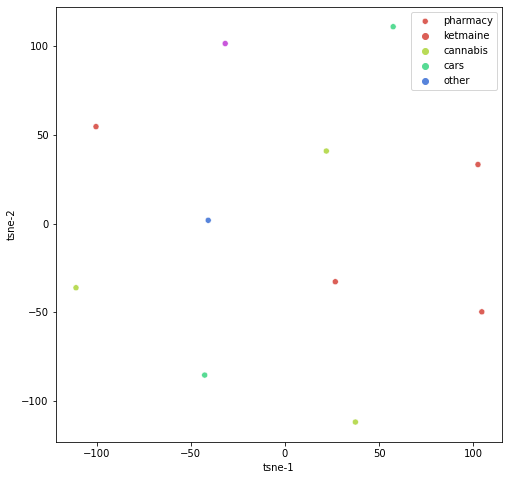

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=plot_tsne_df,
    legend="full",
)
plt.legend(labels=["pharmacy", "ketmaine", "cannabis", "cars", "other"])

In [145]:
tsne_kmeans = KMeans(n_clusters=5)

tsne_kmeans_clusters = kmeans.fit_transform(TSNE_clusters)

cluster_labels = kmeans.labels_

In [149]:
tsne_domains = {'domain': tokens.keys(), 'cluster': cluster_labels, 'total_spent': list(costs.values())}

tsne_df = pd.DataFrame(tsne_domains, index=[clusters], columns=['domain', 'cluster', 'total_spent'])

tsne_df

,domain,cluster,total_spent
0,prestigeglobalchem.com,2,36.50000
0,CJKETAMINESTORE.NET,2,55.00000
2,purechempharma.com,0,24.00000
1,tomh.uk,4,18.00000
2,jungleboyspacks.com,2,16.88000
2,FAITHSTANDARDPHARMACY.COM,4,12.00000
4,K2DRUGSTORE.COM,1,18.00000
1,vland-official.com,1,123.66876
0,megaketaminestore.com,3,24.00000
0,ketamineforsale.com,1,28.88000


In [150]:
tsne_total_spent = tsne_df['total_spent'].groupby(tsne_df['cluster'])

tsne_total_spent.mean()

cluster
0    18.000000
1    56.849587
2    36.126667
3    24.000000
4    15.000000
Name: total_spent, dtype: float64

In [151]:
grouped_df = tsne_df.groupby('cluster')
for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

               domain  cluster  total_spent
2  purechempharma.com        0         24.0
3    MORRISAPOTEK.COM        0         12.0 


                domain  cluster  total_spent
4      K2DRUGSTORE.COM        1     18.00000
1   vland-official.com        1    123.66876
0  ketamineforsale.com        1     28.88000 


                   domain  cluster  total_spent
0  prestigeglobalchem.com        2        36.50
0     CJKETAMINESTORE.NET        2        55.00
2     jungleboyspacks.com        2        16.88 


                  domain  cluster  total_spent
0  megaketaminestore.com        3         24.0 


                      domain  cluster  total_spent
1                    tomh.uk        4         18.0
2  FAITHSTANDARDPHARMACY.COM        4         12.0 


